# Fokker-Planck equation - MVP

The McLachlan Variational Principle can be used both numerically and analytically if the ansatz is expressive enough.

Here use a Gaussian Ansatz ($A(t),\mu(t),\sigma(t)$)

$$
v = A ~ \exp\left( - \dfrac{(x-\mu)^2}{2\sigma^2} \right)
$$

to track the dynamics of an electron distribution function in a strong magnetic field, subject to a Fokker-Planck equation. Here we solve numerically the non-quantum McLachlan Variational Principle. We use the exact Fokker-Planck operator instead of the polynomial approximation.

In this case $\chi_0=10^{-2}$, so the distribution function retains to a good approximation its Gaussian shape.

Check step-by-step solved example calculations in the paper for parameters $(\mu, \sigma)$.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import PDEsolverQRR
from PDEsolverQRR import *
import pandas as pd
#import pennylane as qml
#from pennylane import numpy as np
import pickle
from numpy import exp, sqrt, pi, log
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
# parameters
nqubits = 7
chi0 = 1e-2
tmax = 20.0

mu0 = 1800
sigma0 = 20

tdim = 900 #400
gmlst = np.linspace(200,2200,2**nqubits) #[] energy array
dx = gmlst[1]-gmlst[0]

In [5]:
# time resolution
dt = tmax/tdim

# L matrix
Lmatrix = getL(B=2.5e3 * chi0/(1e-3), tmax=tmax, tdim=tdim, gmlst=gmlst, g0=mu0 )
Lmatrix[0,:] = 0
Lmatrix[-1,:] = 0

# initial target distribution
f0 = np.zeros(2**nqubits)
f0 = exp( -0.5*((gmlst-mu0)/(sigma0) )**2 ) # * np.heaviside(1800-gmlst,0) # 1*dx*g0
f0[0] = 0
f0[-1] = 0
f0_target = f0/sqrt(np.sum(np.abs(f0)**2))

100%|████████████████████████████████████████| 128/128 [00:00<00:00, 506.46it/s]


In [6]:
# analytical solution 1/sqrt(4*pi*k*t) * exp(-x**2/(4*k*t))
def uans(theta):
    """ wavefunction """
    A, mu, sigma = theta
    yth = A * exp(-0.5*(gmlst-mu)**2/sigma**2)
    return yth #/sqrt(np.sum(np.abs(yth)**2))

def dudth(A, mu, sigma):
    """ wavefunction derivatives """
    dx = 1e-4
    dpsi0 = (uans([A+dx, mu, sigma])-uans([A-dx, mu, sigma]))/(2*dx)
    dpsi1 = (uans([A, mu+dx, sigma])-uans([A, mu-dx, sigma]))/(2*dx)
    dpsi2 = (uans([A, mu, sigma+dx])-uans([A, mu, sigma-dx]))/(2*dx)
    return dpsi0, dpsi1, dpsi2

def get_dthetadt(theta):
    """ compute Mkj and Vk elements, and solve matrix equation for derivative of variational parameters """
    A, mu, sigma = theta
    Mkj = np.zeros((3,3))
    Vk = np.zeros(3)
    
    psi = uans(np.array([A, mu, sigma]))
    dpsi0, dpsi1, dpsi2 = dudth(A, mu, sigma)
    Mkj[0,0] = np.sum( dpsi0 * dpsi0 )
    Mkj[0,1] = np.sum( dpsi0 * dpsi1 )
    Mkj[0,2] = np.sum( dpsi0 * dpsi2 )
    Mkj[1,1] = np.sum( dpsi1 * dpsi1 )
    Mkj[1,2] = np.sum( dpsi1 * dpsi2 )
    Mkj[2,2] = np.sum( dpsi2 * dpsi2 )
    
    Mkj[1,0] = Mkj[0,1]
    Mkj[2,0] = Mkj[0,2]
    Mkj[2,1] = Mkj[1,2]
    
    Vk[0] = np.real( np.vdot( dpsi0, Lmatrix @ psi ) )
    Vk[1] = np.real( np.vdot( dpsi1, Lmatrix @ psi ) )
    Vk[2] = np.real( np.vdot( dpsi2, Lmatrix @ psi ) )

    return np.linalg.lstsq(Mkj, Vk)[0] # least squares to avoid numerical instabilities in matrix system

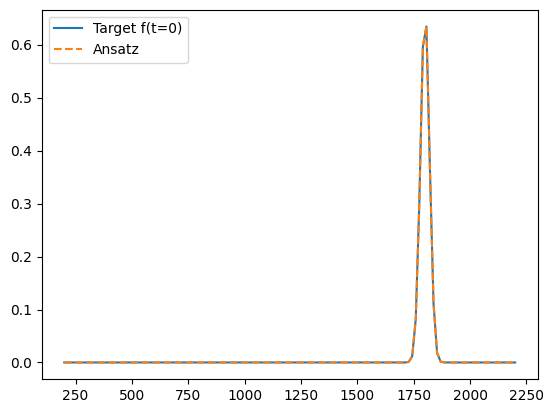

In [7]:
# initial target distribution
A0 = 1/sqrt(np.sum(np.abs(f0)**2))
plt.plot(gmlst, f0_target, label='Target f(t=0)')
plt.plot(gmlst, uans([A0,mu0,sigma0]),'--', label='Ansatz' )
plt.legend()
plt.show()

In [8]:
# solve PDE
fPDElst = np.zeros((tdim,2**nqubits))
fPDE = np.real( np.copy( f0_target ) )
for i in trange(tdim):
    fPDElst[i,:] = fPDE
    fPDE += dt * (np.real(Lmatrix) @ fPDE)

# solve MVP
theta = np.array([A0, mu0, sigma0])
thetalst = np.zeros((tdim,3))
for i in trange(tdim):
    thetalst[i,:] = theta
    theta = theta + get_dthetadt(theta) * dt

100%|███████████████████████████████████████| 900/900 [00:00<00:00, 3973.32it/s]


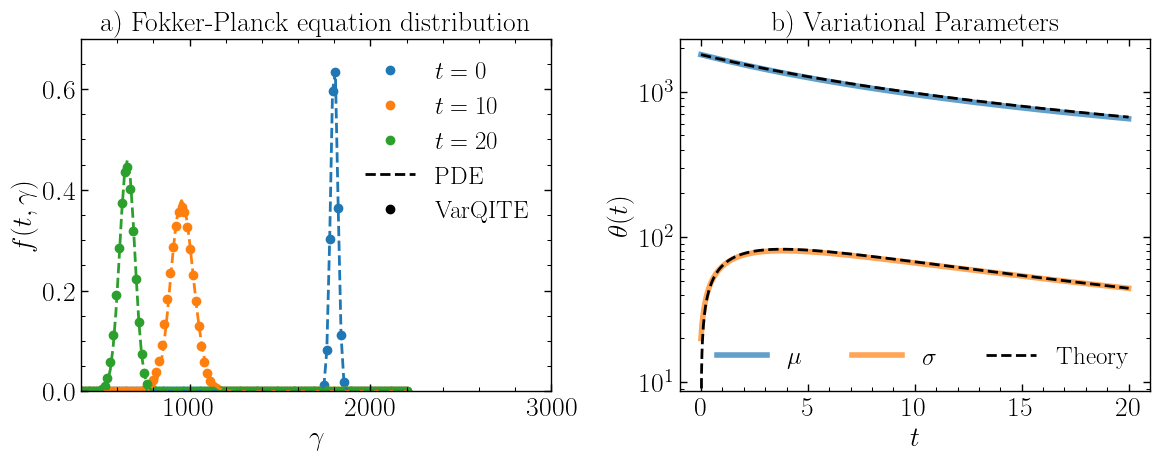

In [11]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2,5))

t = tmax*0.0; i = int(t/tmax * tdim);
yth = np.real( uans(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
maxy = np.max(yth)
axes[0].plot(gmlst, yth, 'o', label=r'$t={:.0f}$'.format(t), color='tab:blue' )
t = tmax*0.5; i = int(t/tmax * tdim);
yth = np.real( uans(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot(gmlst, yth, 'o', label=r'$t={:.0f}$'.format(t), color='tab:orange' )
t = tmax*0.9999; i = int(t/tmax * tdim);
yth = np.real( uans(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot(gmlst, yth, 'o', label=r'$t={:.0f}$'.format(t), color='tab:green' )


yth = fPDElst[0,:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot(gmlst, yth, '--', color='tab:blue' )
yth = fPDElst[int(tdim/2),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot(gmlst, yth, '--', color='tab:orange' )
yth = fPDElst[int(tdim*0.99999),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot(gmlst, yth, '--', color='tab:green' )

# PDE vs VarQITE
axes[0].plot(gmlst, yth-100, 'k--', label='PDE' )
axes[0].plot(gmlst, yth-100, 'ko', label='VarQITE' )

axes[0].set_xlabel(r'$\gamma$')
axes[0].set_ylabel(r'$f(t,\gamma)$')
axes[0].legend(frameon=False, ncol=1, loc='upper right', fontsize=18)
axes[0].set_xlim([400, 3000])
axes[0].set_ylim([0, 0.7])
#plt.title("Heat equation (symmetric): n={}, #blocks={}, #parameters={}, tdim={}".format(nqubits, klayers, nparams, tdim ))
#axes[0].set_title(r"VFPQRR: $\chi_0={}, \mu_0={}, \sigma_0={}$".format(chi0, mu0, sigma0))
axes[0].set_title("a) Fokker-Planck equation distribution ")


# showing the evolution of variational parameters
tlst = np.linspace(0,tmax,tdim)
axes[1].plot(tlst, thetalst[:,1], label=r'$\mu$', linewidth=4, alpha=0.7)
axes[1].plot(tlst, thetalst[:,2], label=r'$\sigma$', linewidth=4, alpha=0.7)
#axes[1].plot(tlst, thetalst[:,0], label=r'$A$')

def get_mean(t, chi0, g0=1800):
    Rc = alpha * 1800 * chi0
    g = 1/(1+2*Rc*t/3) + 55*chi0/(8*sqrt(3)*(1+2/3*Rc*t)**2) * 0.5 * 3*log(1+2*Rc*t/3)
    return g*g0
def get_spread(t, chi0, g0=1800):
    Rc = alpha * 1800 * chi0
    return g0/(1+2*Rc*t/3)**2 * sqrt(55*Rc*chi0*t/(24*sqrt(3)))

axes[1].plot(tlst, get_mean(tlst, chi0), 'k--', label=r'Theory' )
axes[1].plot(tlst, get_spread(tlst, chi0), 'k--' )
#axes[1].plot(tlst, 1/sqrt(pi*thetalst[:,2]**2)*dx, 'k--' )

#plt.xlim([0,50])
axes[1].set_xlabel(r'$t$')
axes[1].set_ylabel(r'$\theta(t)$')
axes[1].set_yscale('log')
axes[1].set_title(r'b) Variational Parameters')
#axes[1].set_title(r'Variational parameters: n={}, tdim={}'.format(nqubits,tdim))
axes[1].legend(frameon=False, ncol=3, fontsize=18)

xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[0].set_aspect(aspect=3/4/axesratio)
#
xmin, xmax = axes[1].get_xlim()
ymin, ymax = axes[1].get_ylim()
axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
axes[1].set_aspect(aspect=3/4/axesratio)

plt.tight_layout()
#plt.savefig("FokkerPlanck_analytical_MVP.pdf", transparent=True)
plt.show()